In [1]:
%%capture

%cd ..
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import itertools
from pathlib import Path

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from heatmap import heatmap, corrplot
from ipywidgets import interact, fixed, interact_manual
from wordcloud import WordCloud

sns.set()
nltk.download('stopwords')

pd.set_option('expand_frame_repr', True)
pd.set_option('display.column_space', 6)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.show_dimensions', True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/limagbz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis

This notebook can be used to reproduce the exploratory data analysis.

## Setup

In [3]:
PROCESSED_DATA_FOLDER = Path('data/processed/')

## Data Loading

In [4]:
data_df = pd.read_csv(PROCESSED_DATA_FOLDER/"fake_true_news_cleaned_features.csv", index_col=0)
data_df["class"] = data_df["class"].astype('category')

CONTINUOUS_VARIABLES = [x for x, y in data_df.dtypes.iteritems() if str(y) not in ('category', 'object')]
CONTINUOUS_VARIABLES.remove('file_index')

## Summary

First, let's do a quick summary of the data for both classes

In [5]:
data_df[data_df['class'] == 'True'].describe().T

,count,mean,std,min,25%,50%,75%,max
file_index,3582.0,1806.654662,1038.699988,1.000000,909.250000,1807.500000,2705.750000,3602.000000
tokens,3582.0,1270.411781,789.441222,22.000000,739.250000,1061.000000,1632.750000,8634.000000
pausality,3582.0,3.043254,1.294177,0.500000,2.555560,2.960365,3.416670,51.238100
characters,3582.0,5385.958124,3337.538868,90.000000,3119.000000,4510.500000,6946.750000,37381.000000
average_sentence_length,3582.0,21.149550,5.247414,5.000000,17.951200,20.581100,23.812200,110.250000
average_word_lenght,3582.0,4.866084,0.195067,3.950190,4.740992,4.868025,4.990342,5.750990
percentage_spelling_errors,3582.0,0.002276,0.005118,0.000000,0.000000,0.001267,0.002874,0.231151
emotiveness,3582.0,0.213868,0.060421,0.035088,0.170166,0.206452,0.250389,0.590258
diversity,3582.0,0.474077,0.071204,0.000000,0.429882,0.471530,0.517388,0.900000
percent_types,3582.0,41.528992,6.022568,14.123007,37.551370,41.201093,45.097016,86.363636


In [6]:
data_df[data_df['class'] == 'Fake'].describe().T

,count,mean,std,min,25%,50%,75%,max
file_index,3600.0,1801.899444,1040.063208,1.000000,901.750000,1802.500000,2702.250000,3602.000000
tokens,3600.0,216.236667,147.300962,11.000000,135.000000,185.000000,261.000000,2625.000000
pausality,3600.0,2.468517,0.911004,0.250000,1.888890,2.339740,2.900000,12.200000
characters,3600.0,896.441944,615.194546,34.000000,553.000000,759.000000,1078.250000,10610.000000
average_sentence_length,3600.0,15.307048,5.444366,2.666670,11.555600,15.000000,18.333300,78.333300
average_word_lenght,3600.0,4.824780,0.286985,3.615940,4.642860,4.813740,5.002377,5.935780
percentage_spelling_errors,3600.0,0.003859,0.009681,0.000000,0.000000,0.000000,0.005780,0.382353
emotiveness,3600.0,0.205708,0.078667,0.000000,0.151515,0.200000,0.253086,0.750000
diversity,3600.0,0.668729,0.112169,0.000000,0.625790,0.673410,0.720000,1.000000
percent_types,3600.0,58.194289,6.707981,29.971182,53.903389,57.746479,62.174476,90.000000


## Correlation Analysis

First, let's define the functions that we are going to use to do the correlation analysis. They are the correlation matrix and the joint plot graphs. We are also going to see the top correlations. They are defined below:

### Functions Definitions

In [7]:
def correlation_matrix(df, method='spearman', filter_variables=[], class_name='all'):
    fig = plt.figure(figsize=(10, 10))
    
    if class_name != 'all':
        data = df[df['class'] == class_name][filter_variables]
    else:
        data = df[filter_variables]
    
    corrplot(data.corr(method=method), size_scale=250, marker='o')
    fig.axes[0].tick_params(axis="x", labelsize=10)
    fig.axes[0].tick_params(axis="y", labelsize=10)
    fig.axes[1].tick_params(axis="x", labelsize=10)
    fig.axes[1].tick_params(axis="x", labelsize=10)
    
    return fig

def get_top_abs_correlations(df, method="spearman"):
    
    # Drop redundant pairs of columns
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    
    # Calculate Correlation
    au_corr = df.corr(method=method).unstack()
    au_corr = au_corr.drop(labels=pairs_to_drop)
    
    return au_corr

def correlation_data_table(df, n_variables=12, class_name='all', filter_variables=[]):
    
    if class_name != 'all':
        data = df[df['class'] == class_name][filter_variables]
    else:
        data = df[filter_variables]
    
    correlation_data = get_top_abs_correlations(data[filter_variables])
    top_pos_corr = correlation_data[correlation_data >= 0].sort_values(ascending=False)[0:n_variables]
    top_neg_corr = correlation_data[correlation_data <= 0].sort_values(ascending=True)[0:n_variables]

    t = pd.DataFrame(pd.concat([top_pos_corr, top_neg_corr], keys=['positive', 'negative']))
    t = t.rename(columns={0: "ρ"})
    s = t.style
    s = s.bar(subset=["ρ"], align='mid', color=['#d65f5f', '#5fba7d'])
    
    return s

def continuous_jointplot(df, variable_x, variable_y, kwargs={}):
    sns_plot = sns.jointplot(x=variable_x, y=variable_y, data=df, hue='class', **kwargs)
    return sns_plot

### Analysis

First, let's take a look at the correlation matrix

In [8]:
interact_manual(correlation_matrix, class_name=['all', 'True', 'Fake'], df=fixed(data_df), method=fixed('spearman'), filter_variables=fixed(CONTINUOUS_VARIABLES))

interactive(children=(Dropdown(description='class_name', options=('all', 'True', 'Fake'), value='all'), Button…

<function __main__.correlation_matrix(df, method='spearman', filter_variables=[], class_name='all')>

We can also see the values of the correlations

In [9]:
interact_manual(correlation_data_table, class_name=['all', 'True', 'Fake'], df=fixed(data_df), filter_variables=fixed(CONTINUOUS_VARIABLES))

interactive(children=(IntSlider(value=12, description='n_variables', max=36, min=-12), Dropdown(description='c…

<function __main__.correlation_data_table(df, n_variables=12, class_name='all', filter_variables=[])>

Finally, we can take a look at the joint plots

In [10]:
interact_manual(
    continuous_jointplot, variable_x=CONTINUOUS_VARIABLES, variable_y=CONTINUOUS_VARIABLES, 
    df=fixed(data_df), kwargs=fixed({}),
)

interactive(children=(Dropdown(description='variable_x', options=('tokens', 'pausality', 'characters', 'averag…

<function __main__.continuous_jointplot(df, variable_x, variable_y, kwargs={})>

### Conclusions

## Distribution

Now let's compare the distributions for both classes.

In [11]:
def continuous_univariate_plots(df, variable, jitter, hue='class', figsize=(30,5)):

    # Preparing Data
    df["all"] = ""
    
    # Setup Figure
    N_ROWS, N_COLUMNS = 2, 4
    fig = plt.figure(figsize=figsize)
    fig.suptitle(f'{variable} (n={len(df)})')
    
    ax1 = plt.subplot2grid((N_ROWS, N_COLUMNS), (0, 0), colspan=1)
    ax2 = plt.subplot2grid((N_ROWS, N_COLUMNS), (0, 1), colspan=1)
    ax3 = plt.subplot2grid((N_ROWS, N_COLUMNS), (0, 2), colspan=1)
    ax4 = plt.subplot2grid((N_ROWS, N_COLUMNS), (0, 3), colspan=1)
    ax5 = plt.subplot2grid((N_ROWS, N_COLUMNS), (1, 0), colspan=2)
    ax6 = plt.subplot2grid((N_ROWS, N_COLUMNS), (1, 2), colspan=2)
    
    # Plots: Distribution plot
    mean, mode, median = df[variable].mean(), df[variable].mode()[0], df[variable].median()
    sns.histplot(x=variable, hue=hue, data=df, ax=ax1)
    ax1.axvline(mean, color='r', linestyle='--')
    ax1.axvline(mode, color='g', linestyle='-')
    ax1.axvline(median, color='y', linestyle='-')
    ax1.legend({'Mean': mean, 'Median': median, 'Mode': mode})
    ax1.set_title("Distribution Plot (skew=%.2f, kurt=%.2f)" %(df[variable].skew(), df[variable].kurtosis()))
    
    # Plots: Violin & Jitter 
    sns.violinplot(x=variable, y="all", hue=hue, data=df, cut=True, split=True, vars=df.columns, ax=ax2)
    if jitter == "strip": 
        sns.stripplot(x=variable, y="all", data=df, hue=hue, ax=ax2, alpha=.25)
    elif jitter == "swarm":
        sns.swarmplot(x=variable, y="all", data=df, hue=hue, ax=ax2, alpha=.25)
    ax2.set_title("Violin Plot")
    ax2.set_ylabel("")
    
    # Plots: Boxplot
    sns.boxplot(x=variable, y='all', data=df, ax=ax3, hue=hue)
    ax3.set_title("Box-and-Whisker Plot")
    
    # Plots: Boxen Plot
    sns.boxenplot(x=variable, y='all', data=df, showfliers=True, hue=hue, ax=ax4)
    ax4.set_title("Boxen Plot")
    
    # Plots: Probability Plot
    stats.probplot(df[variable], dist='norm', fit=True, plot=ax5)
    ax5.set_title("Probability Plot")
    
    # Plots: Index Plot
    ax6.plot(df[variable], ".")
    ax6.set_title("Index Plot")
    ax6.set_xlabel("Row Index")
    ax6.set_ylabel("Value")
    
    # Remove Modifications on Data
    df = df.drop(columns=['all'])
    
    # Show Plot
    plt.show()

In [12]:
interact_manual(
    continuous_univariate_plots, 
    variable=CONTINUOUS_VARIABLES, 
    jitter=[None, "strip", "swarm"], 
    hue=[None] + list(data_df.columns) ,
    df=fixed(data_df), 
    figsize=fixed((25,12))
)

interactive(children=(Dropdown(description='variable', options=('tokens', 'pausality', 'characters', 'average_…

<function __main__.continuous_univariate_plots(df, variable, jitter, hue='class', figsize=(30, 5))>

### Conclusions

## Word Cloud

First, let's tokenize the corpus

In [13]:
list_of_words_fake = ' '.join(list(data_df[data_df["class"] == 'Fake'].text))
list_of_words_fake = [word for word in list_of_words_fake.split(" ") if word not in nltk.corpus.stopwords.words('portuguese')]

list_of_words_true = ' '.join(list(data_df[data_df["class"] == 'True'].text))
list_of_words_true = [word for word in list_of_words_true.split(" ") if word not in nltk.corpus.stopwords.words('portuguese')]

And than plot the data, First for fake news:

### Fake News

(-0.5, 399.5, 199.5, -0.5)

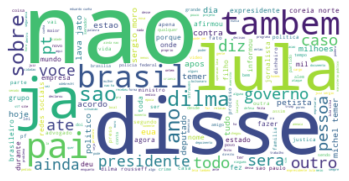

In [14]:
fake_wordcloud = WordCloud(max_words=1000, background_color="white").generate(" ".join(list_of_words_fake))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

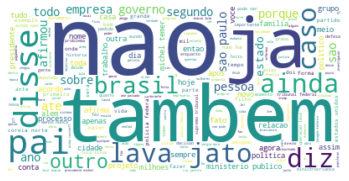

In [15]:
true_wordcloud = WordCloud(max_words=1000, background_color="white").generate(" ".join(list_of_words_true))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis("off")

## Exporting Images

In [18]:
%%capture

FIGURES_PATH = Path("reports/figures/eda")
FIGURES_PATH.mkdir(exist_ok=True, parents=True)

data_df['all'] = ""

# Correlation Matrix
CORR_MATRIX_FIGURES_PATH = FIGURES_PATH / "corr_matrix"
CORR_MATRIX_FIGURES_PATH.mkdir(exist_ok=True, parents=True)

fig = correlation_matrix(data_df, method='spearman', filter_variables=CONTINUOUS_VARIABLES, class_name='all')
fig.savefig(CORR_MATRIX_FIGURES_PATH / f'corr_matrix_all_classes.jpg', bbox_inches='tight')
fig = correlation_matrix(data_df, method='spearman', filter_variables=CONTINUOUS_VARIABLES, class_name='True')
fig.savefig(CORR_MATRIX_FIGURES_PATH / f'corr_matrix_true.jpg', bbox_inches='tight')
fig = correlation_matrix(data_df, method='spearman', filter_variables=CONTINUOUS_VARIABLES, class_name='Fake')
fig.savefig(CORR_MATRIX_FIGURES_PATH / f'corr_matrix_fake.jpg', bbox_inches='tight')

# Joint Plots
JOINT_PLOTS_FIGURES_PATH = FIGURES_PATH / "joint"
JOINT_PLOTS_FIGURES_PATH.mkdir(exist_ok=True, parents=True)

correlation_pairs = list(get_top_abs_correlations(data_df[CONTINUOUS_VARIABLES]).index)
for var1, var2 in correlation_pairs:
    fig = continuous_jointplot(data_df, var1, var2)
    fig.savefig(JOINT_PLOTS_FIGURES_PATH / f'corr_matrix_{var1}_{var2}.jpg', bbox_inches='tight')    

# Wordcloud
WORDCLOUD_PLOTS_FIGURES_PATH = FIGURES_PATH / "wordcloud"
WORDCLOUD_PLOTS_FIGURES_PATH.mkdir(exist_ok=True, parents=True)

fake_wordcloud.to_file(WORDCLOUD_PLOTS_FIGURES_PATH/'wordcloud_fake.png')
true_wordcloud.to_file(WORDCLOUD_PLOTS_FIGURES_PATH/'wordcloud_true.png')

# Distributions
DISTRIBUTION_PLOTS_FIGURES_PATH = FIGURES_PATH / "distribution"
DISTRIBUTION_PLOTS_FIGURES_PATH.mkdir(exist_ok=True, parents=True)

for variable in CONTINUOUS_VARIABLES:
    mean, mode, median = data_df[variable].mean(), data_df[variable].mode()[0], data_df[variable].median()
    fig = plt.figure()
    ax1 = sns.histplot(x=variable, hue='class', data=data_df)
    ax1.axvline(mean, color='r', linestyle='--')
    ax1.axvline(mode, color='g', linestyle='-')
    ax1.axvline(median, color='y', linestyle='-')
    ax1.legend({'Mean': mean, 'Median': median, 'Mode': mode})
    ax1.set_title("Distribution Plot (skew=%.2f, kurt=%.2f)" %(data_df[variable].skew(), data_df[variable].kurtosis()))
    fig.savefig(DISTRIBUTION_PLOTS_FIGURES_PATH / f'distribution_{variable}.jpg', bbox_inches='tight')

# Violin
VIOLIN_PLOTS_FIGURES_PATH = FIGURES_PATH / "violin"
VIOLIN_PLOTS_FIGURES_PATH.mkdir(exist_ok=True, parents=True)

for variable in CONTINUOUS_VARIABLES:
    fig = plt.figure()
    sns.violinplot(x=variable, y="all", hue='class', data=data_df, cut=True, split=True, vars=data_df.columns)
    fig.get_axes()[0].set_ylabel("")
    fig.savefig(VIOLIN_PLOTS_FIGURES_PATH / f'violin_{variable}.jpg', bbox_inches='tight')

# Box and Whisker
BOX_PLOTS_FIGURES_PATH = FIGURES_PATH / "box"
BOX_PLOTS_FIGURES_PATH.mkdir(exist_ok=True, parents=True)

for variable in CONTINUOUS_VARIABLES:
    fig = plt.figure()
    sns.boxplot(x=variable, y='all', data=data_df, hue='class')
    fig.get_axes()[0].set_ylabel("")
    fig.savefig(BOX_PLOTS_FIGURES_PATH / f'box_{variable}.jpg', bbox_inches='tight')

# Boxen Plots
BOXEN_PLOTS_FIGURES_PATH = FIGURES_PATH / "boxen"
BOXEN_PLOTS_FIGURES_PATH.mkdir(exist_ok=True, parents=True)

for variable in CONTINUOUS_VARIABLES:
    fig = plt.figure()
    sns.boxenplot(x=variable, y='all', data=data_df, hue='class', showfliers=True)
    fig.get_axes()[0].set_ylabel("")
    fig.savefig(BOXEN_PLOTS_FIGURES_PATH / f'boxen_{variable}.jpg', bbox_inches='tight')

# Q-Q plots
QQ_PLOTS_FIGURES_PATH = FIGURES_PATH / "QQ"
QQ_PLOTS_FIGURES_PATH.mkdir(exist_ok=True, parents=True)

for variable in CONTINUOUS_VARIABLES:
    fig, ax = plt.subplots()
    stats.probplot(data_df[variable], dist='norm', fit=True, plot=ax)
    fig.savefig(QQ_PLOTS_FIGURES_PATH / f'qq_{variable}.jpg', bbox_inches='tight')

# Index Plots
INDEX_PLOTS_FIGURES_PATH = FIGURES_PATH / "index"
INDEX_PLOTS_FIGURES_PATH.mkdir(exist_ok=True, parents=True)

for variable in CONTINUOUS_VARIABLES:
    fig, ax = plt.subplots()
    ax.plot(data_df[variable], ".")   
    fig.savefig(INDEX_PLOTS_FIGURES_PATH / f'index_{variable}.jpg', bbox_inches='tight')

data_df = data_df.drop(columns=['all'])